In [1]:
import os
import os.path as osp

import copy
import math

%matplotlib inline

import random
import xml.etree.ElementTree as ET
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import json
from PIL import Image

import itertools
from math import sqrt

import matplotlib.patches as patches # For bounding boxes

import torch
import torch.nn as nn
from torch import nn, optim
from torch.autograd import Function
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torch.utils.data import Dataset, DataLoader, sampler, random_split
import torchvision.transforms as T
from torchvision import datasets, models
from torchvision.transforms import functional as FT

plt.rcParams['figure.figsize'] = (15, 15)

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [2]:
!pip install pycocotools
from pycocotools.coco import COCO

  Obtaining dependency information for pycocotools from https://files.pythonhosted.org/packages/ba/64/0451cf41a00fd5ac4501de4ea0e395b7d909e09d665e56890b5d3809ae26/pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 2.5 MB/s eta 0:00:00a 0:00:01m


In [3]:
import json
path = "/kaggle/input/data-deep/coco_minitrain_25k/annotations/instances_minitrain2017.json"
f = open(path)
f1 = open('/kaggle/input/data-deep/coco_minitrain_25k/annotations/instances_val2017.json')
anns = json.load(f)
anns1 = json.load(f1)
print(anns.keys())

dict_keys(['images', 'info', 'licenses', 'annotations', 'categories'])


In [ ]:
print(anns['categories'])
print(anns1['categories'])

In [4]:
image_ids_annotations = defaultdict(list)

classes=dict()

# Add into datastructure
for ann in anns['annotations']:
    image_id = ann['image_id'] # Are integers
    image_ids_annotations[image_id].append(ann)
    
for ann in anns['categories']:
    classes[ann['id']] = ann['name']

In [5]:
category_id_to_name = dict()
for ann in anns['categories']:
    category_id_to_name[ann['id']] = ann['name']

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import json
from PIL import Image
import matplotlib.patches as patches

image_name = "/kaggle/input/data-deep/coco_minitrain_25k/images/train2017/000000000025.jpg"
image_id = int(image_name.split("/")[-1].split(".")[0])

img = Image.open(image_name)
fig, ax = plt.subplots()

# Add code to visualize boxes and labels
image_anns = image_ids_annotations[image_id]

# Get all bounding boxes and labels
for image_ann in image_anns:
    bbox = image_ann['bbox'] # Format: x, y, h, w, origin in top left corner
    name = category_id_to_name[image_ann['category_id']]
    confidence = image_ann['score'] if 'score' in image_ann else None

    # Extract bbox coordinates
    x = float(bbox[0])
    y = float(bbox[1])
    w = float(bbox[2])
    h = float(bbox[3])

    # Add text and bbox
    label_text = f"{name} ({confidence:.2%})" if confidence is not None else name
    plt.text(x+1, y-5, name,fontdict={'fontsize':18.0, 'fontweight':'medium','color': 'white', 'backgroundcolor':'red'})
    bb = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(bb)

ax.axis('off')
ax.imshow(img)
plt.show()

In [2]:
!pip install albumentations

In [6]:
num_classes = 91

# Dataset 

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
def get_transforms(train=False):
  if train:
    transform=A.Compose([
        A.Resize(300,300),
        A.HorizontalFlip(p=0.25),
        A.VerticalFlip(p=0.3),
        A.RandomBrightnessContrast(p=0.1),
        A.ColorJitter(p=0.1),
        ToTensorV2()
    ],bbox_params=A.BboxParams(format='coco'))
  else:
    transform = A.Compose([
            A.Resize(300, 300), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
  return transform

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotations, transforms=None):
        super(CocoDataset, self).__init__()
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotations)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def _load_image(self, id):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id)) 

    def __getitem__(self, index):
        coco = self.coco
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        ann_ids = coco.getAnnIds(imgIds=id)
        coco_annotation = coco.loadAnns(ann_ids)
        boxes = [t['bbox'] + [t['category_id']] for t in target]
        num_objs = len(coco_annotation)
        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes)
        image = transformed['image']
        
        boxes = transformed["bboxes"]

        new_boxes=[]
        for box in boxes:
          xmin=box[0]
          xmax=xmin+box[2]
          ymin=box[1]
          ymax=ymin+box[3]
          new_boxes.append([xmin,ymin,xmax,ymax])
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target],dtype=torch.int64)
        
        return image.div(255), targ

    def __len__(self):
        return len(self.ids)

In [9]:
train_root="/kaggle/input/data-deep/coco_minitrain_25k/images/train2017/"
train_coco="/kaggle/input/data-deep/coco_minitrain_25k/annotations/instances_minitrain2017.json"
val_root="/kaggle/input/data-deep/coco_minitrain_25k/images/val2017"
val_coco="/kaggle/input/data-deep/coco_minitrain_25k/annotations/instances_val2017.json"

In [10]:
train_dataset=CocoDataset(train_root,train_coco,get_transforms(True))
val_dataset=CocoDataset(val_root,val_coco,get_transforms(False))

loading annotations into memory...
Done (t=5.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.66s)
creating index...
index created!


In [ ]:
print(classes)

In [ ]:
sample = train_dataset[0]
print(sample)

In [ ]:
from torchvision.utils import draw_bounding_boxes
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels'].tolist()], width=4
).permute(1, 2, 0))

In [ ]:
def collate_fn(batch):
    targets = []
    imgs = []
    
    for sample in batch:
        imgs.append(sample[0])
        targets.append({'boxes': sample[1]['boxes'], 'labels': sample[1]['labels']})
    #[3, 300, 300]
    #(batch_size, 3, 300 x 300)
    imgs = torch.stack(imgs, dim = 0)
    
    return imgs, targets

# Dataloader

In [ ]:
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn = collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False, collate_fn = collate_fn)

In [ ]:
batch_iter = iter(train_dataloader)
images, targets = next(batch_iter)#get 1 sample
print(images)
print(targets)

# Model

In [11]:
from torchvision.models.detection import ssd300_vgg16

In [ ]:
model = ssd300_vgg16()

In [ ]:
images,targets=next(iter(train_dataloader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
model(images,targets)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
learning_rate=0.0001
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login(key='7bf356c877ffe622d42fffac7ed907c2ebc210ba')
wandb.init(project="dl-project", name="toasty-totem-4")

In [ ]:
import time
def train(model, train_dataloader, valid_dataloader, epoch, display_step):
    print(f"Start epoch #{epoch+1}")
    start_time = time.time()
    train_loss_epoch = 0
    test_loss_epoch = 0
    last_loss = 999999999
    model.train()
    for i, (data,targets) in enumerate(train_dataloader):
        
        # Load data into GPU
        data = data.to(device)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        outputs = model(data, targets)

        # Backpropagation, compute gradients
        
        loss = sum(l for l in outputs.values())
        if i % 1250 == 0:
            wandb.log({k:v for k,v in outputs.items()})
        loss.backward()

        # Apply gradients
        optimizer.step()
        
        # Save loss
        train_loss_epoch += loss.item()
        if (i+1) % display_step == 0:
#             accuracy = float(test(test_loader))
            print('Train Epoch: {} [{}/{} ({}%)]\tLoss: {:.4f}'.format(
                epoch + 1, (i+1) * len(data), len(train_dataloader.dataset), 100 * (i+1) * len(data) / len(train_dataloader.dataset), 
                loss.item()))
                  
    print(f"Done epoch #{epoch+1}, time for this epoch: {time.time()-start_time}s")
    train_loss_epoch /= (i + 1)

    return train_loss_epoch

In [ ]:
num_epoch = 5
train_loss_array = []
test_loss_array = []
last_loss = 9999999999999


for epoch in range(num_epoch):
    train_loss_epoch = 0
    test_loss_epoch = 0
    train_loss_epoch = train(model, train_dataloader, val_dataloader, epoch, 500)
    wandb.log({'Train loss': train_loss_epoch})
    
    if train_loss_epoch < last_loss:
        last_loss = train_loss_epoch
        torch.save({'model_state_dict': model.state_dict(), 'optimizer_state': optimizer.state_dict()}, 'ssd300.pth')
    train_loss_array.append(train_loss_epoch)
    

In [12]:
# Load model to continue train
checkpoint_path = '/kaggle/input/checkpoint2/ssd300.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Load the model state dictionary
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state'])
num_epoch = 15
train_loss_array = []
test_loss_array = []
last_loss = 9999999999999


for epoch in range(num_epoch):
    train_loss_epoch = 0
    test_loss_epoch = 0
    train_loss_epoch = train(model, train_dataloader, val_dataloader, epoch, 500)
    wandb.log({'Train loss': train_loss_epoch})
    
    if train_loss_epoch < last_loss:
        last_loss = train_loss_epoch
        torch.save({'model_state_dict': model.state_dict(), 'optimizer_state': optimizer.state_dict()}, 'ssd300.pth')
    train_loss_array.append(train_loss_epoch)

KeyboardInterrupt: 

In [13]:
!pip install torchmetrics

In [22]:
model.eval()
img, _ = val_dataset[321]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]
print(pred['scores'], pred['labels'])

tensor([0.3769, 0.2974, 0.2889, 0.2295, 0.1888, 0.1789, 0.1770, 0.1701, 0.1673,
        0.1664, 0.1564, 0.1536, 0.1410, 0.1392, 0.1378, 0.1356, 0.1353, 0.1340,
        0.1337, 0.1292, 0.1286, 0.1270, 0.1266, 0.1249, 0.1249, 0.1239, 0.1235,
        0.1234, 0.1234, 0.1228, 0.1224, 0.1219, 0.1218, 0.1215, 0.1209, 0.1208,
        0.1208, 0.1205, 0.1205, 0.1202, 0.1189, 0.1188, 0.1188, 0.1178, 0.1172,
        0.1170, 0.1168, 0.1168, 0.1164, 0.1163, 0.1160, 0.1154, 0.1153, 0.1153,
        0.1150, 0.1148, 0.1143, 0.1142, 0.1136, 0.1132, 0.1132, 0.1130, 0.1128,
        0.1125, 0.1123, 0.1120, 0.1120, 0.1052, 0.0875, 0.0753, 0.0725, 0.0685,
        0.0657, 0.0616, 0.0573, 0.0553, 0.0544, 0.0528, 0.0522, 0.0503, 0.0498,
        0.0495, 0.0493, 0.0491, 0.0480, 0.0476, 0.0470, 0.0453, 0.0449, 0.0437,
        0.0430, 0.0430, 0.0413, 0.0412, 0.0410, 0.0410, 0.0408, 0.0406, 0.0405,
        0.0399, 0.0399, 0.0399, 0.0398, 0.0398, 0.0396, 0.0396, 0.0392, 0.0392,
        0.0387, 0.0386, 0.0386, 0.0386, 

/tmp/ipykernel_42/2386326166.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_int = torch.tensor(img*255, dtype=torch.uint8)


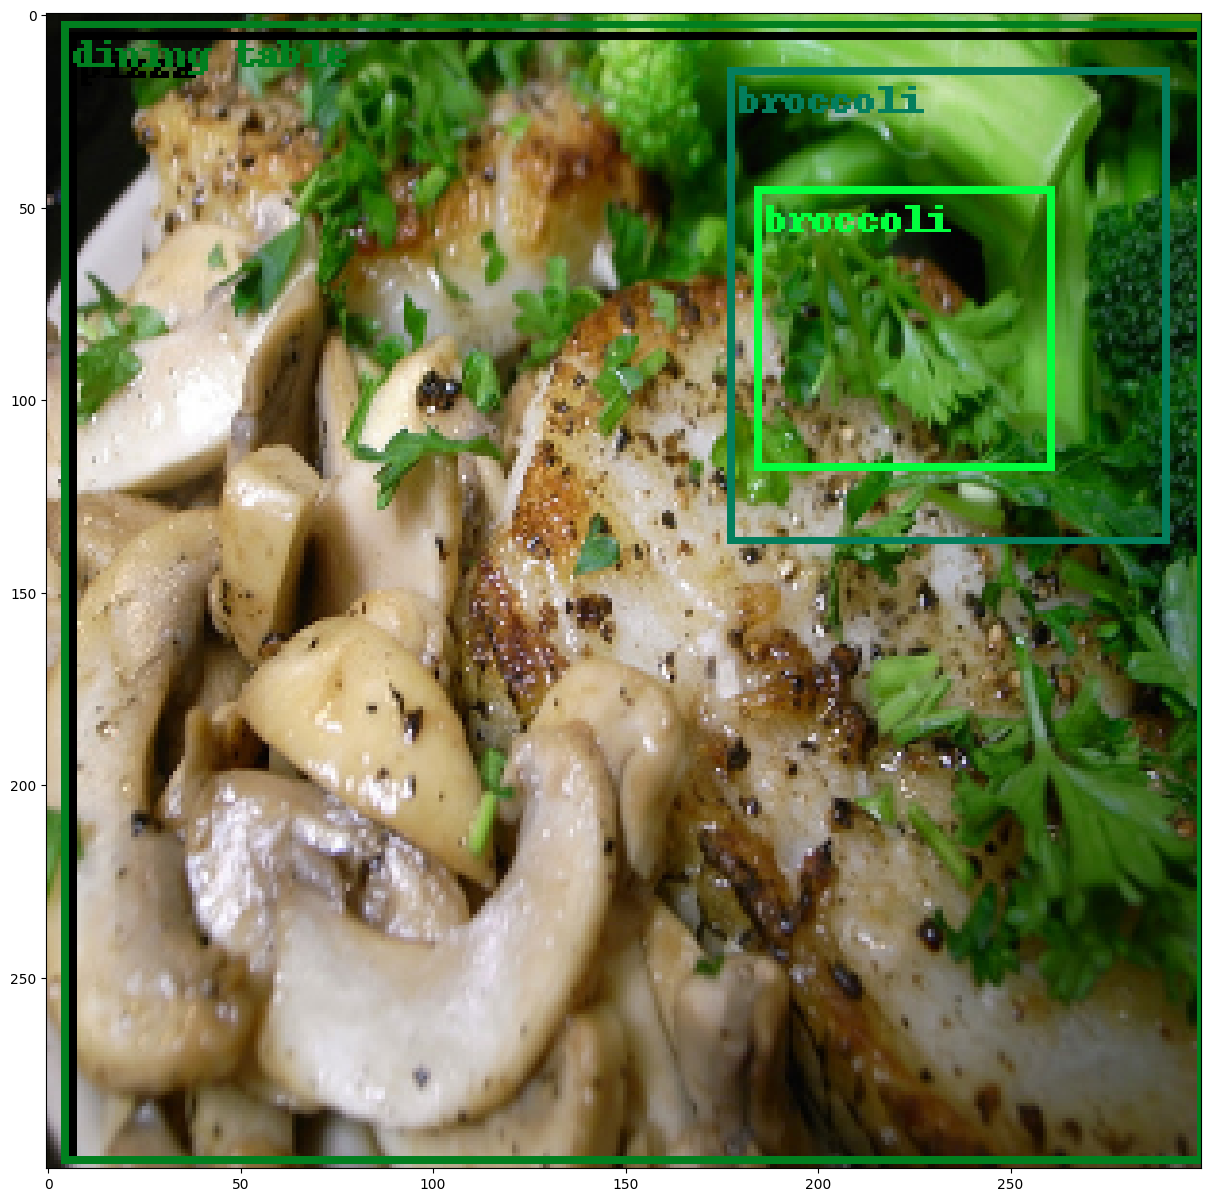

In [26]:
from torchvision.utils import draw_bounding_boxes
fig = plt.figure(figsize=(20, 15))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.2],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.2].tolist()], width=2
).permute(1, 2, 0))

In [ ]:
print(val_dataset[0])

In [15]:
model = ssd300_vgg16(pretrained=False)
checkpoint_path = '/kaggle/input/checkpoint2/ssd300.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Load the model state dictionary
model.load_state_dict(checkpoint['model_state_dict'])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [20]:
from torchmetrics.detection import MeanAveragePrecision

model.eval()

metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5])

# Iterate through the validation dataset
for img, target in val_dataset:
    img = img.to(device).unsqueeze(0)  # Add batch dimension
    target = [{k: v.to(device) for k, v in target.items()}]

    with torch.no_grad():
        prediction = model(img)

    # Update the metric with the current prediction and target
    metric.update(prediction, target)

# Compute and print mAP
mAP = metric.compute()
print(f"Mean Average Precision (mAP): {mAP}")
    

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


Mean Average Precision (mAP): {'map': tensor(0.2588), 'map_50': tensor(0.2588), 'map_75': tensor(-1.), 'map_small': tensor(0.0801), 'map_medium': tensor(0.2873), 'map_large': tensor(0.4394), 'mar_1': tensor(0.2743), 'mar_10': tensor(0.4437), 'mar_100': tensor(0.4860), 'mar_small': tensor(0.2411), 'mar_medium': tensor(0.5664), 'mar_large': tensor(0.6964), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
        41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
        82, 84, 85, 86, 87, 88, 89, 90], dtype=torch.int32)}


In [21]:
from torchmetrics.detection import MeanAveragePrecision
model = ssd300_vgg16(weights='COCO_V1')
model.to(device)
model.eval()

metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5])

# Iterate through the validation dataset
for img, target in val_dataset:
    img = img.to(device).unsqueeze(0)  # Add batch dimension
    target = [{k: v.to(device) for k, v in target.items()}]

    with torch.no_grad():
        prediction = model(img)

    # Update the metric with the current prediction and target
    metric.update(prediction, target)

# Compute and print mAP
mAP = metric.compute()
print(f"Mean Average Precision (mAP): {mAP}")
    

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:01<00:00, 140MB/s]  
/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


Mean Average Precision (mAP): {'map': tensor(0.4095), 'map_50': tensor(0.4095), 'map_75': tensor(-1.), 'map_small': tensor(0.1376), 'map_medium': tensor(0.5289), 'map_large': tensor(0.6681), 'mar_1': tensor(0.3523), 'mar_10': tensor(0.5480), 'mar_100': tensor(0.6008), 'mar_small': tensor(0.2695), 'mar_medium': tensor(0.7864), 'mar_large': tensor(0.8398), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
        41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
        82, 84, 85, 86, 87, 88, 89, 90], dtype=torch.int32)}
